In [5]:
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [4]:
import os
print(os.environ["LD_LIBRARY_PATH"])

:/home/nkspartan/miniconda3/envs/tf-gpu/lib/:/home/nkspartan/miniconda3/envs/tf-gpu/lib/


In [27]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import keras

from keras import Sequential, models, Input
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU
from keras.optimizers import SGD, Adam

In [28]:
from tensorflow.python.client import device_lib

#print(device_lib.list_local_devices())
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2022-10-13 22:40:45.131397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 22:40:45.131676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 22:40:45.131885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 22:40:45.132157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 22:40:45.132379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Read the csv dataset to get the values for stage and discharge of the images

In [29]:
df = pd.read_csv("../../dataset/2012_2019_PlatteRiverWeir_features_merged_all.csv")
df.head()

,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
df = df[["Filename", "Stage", "Discharge"]]

### Scale the data

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [32]:
df[["Stage", "Discharge"]] = scaler.fit_transform(df[["Stage", "Discharge"]])
df


,Filename,Stage,Discharge
0,StateLineWeir_20120609_Farrell_001.jpg,0.138117,-0.046094
1,StateLineWeir_20120609_Farrell_002.jpg,0.138117,-0.046094
2,StateLineWeir_20120609_Farrell_003.jpg,0.100875,-0.082160
3,StateLineWeir_20120609_Farrell_004.jpg,0.076046,-0.104807
4,StateLineWeir_20120609_Farrell_005.jpg,0.076046,-0.104807
...,...,...,...
42054,StateLineWeir_20191011_Farrell_409.jpg,-0.420526,-0.450369
42055,StateLineWeir_20191011_Farrell_410.jpg,-0.420526,-0.450369
42056,StateLineWeir_20191011_Farrell_411.jpg,-0.420526,-0.450369
42057,StateLineWeir_20191011_Farrell_412.jpg,-0.420526,-0.450369


In [33]:
from joblib import dump, load
dump(scaler, 'std_scaler.joblib', compress=True)

['std_scaler.joblib']

## Create the dataset pipeline

In [34]:
IMG_SIZE = 512
BATCH_SIZE = 32

In [35]:
from glob import glob

def make_dataset(path, batch_size, df, seed=None):
  np.random.seed(seed)

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)
    image /= 255
    return image

  def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

  filenames = glob(path + '/*')
  
  # make train, val and test splits of the dataset (70%, 10%, 20% split)
  split1 = int(0.7 * len(filenames))
  split2 = int(0.8 * len(filenames))

  np.random.shuffle(filenames)
  train_files = filenames[:split1] # up to split 1 (ex 70%)
  val_files = filenames[split1:split2] # from ex. 70% to 80%
  test_files = filenames[split2:] # from ex. 80% until the end

  # create stage values
  stage_train_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in train_files]
  stage_val_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in val_files]
  stage_test_values = [df[df.Filename == file.split('/')[-1]].Stage.values for file in test_files]

  # create discharge values
  discharge_train_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in train_files]
  discharge_val_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in val_files]
  discharge_test_values = [df[df.Filename == file.split(
      '/')[-1]].Discharge.values for file in test_files]

  # join stage and discharge values
  stage_discharge_train_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_train_values, discharge_train_values)]
  stage_discharge_val_values = [[np.squeeze(s), np.squeeze(d)] for s, d in zip(stage_val_values, discharge_val_values)]
  stage_discharge_test_values = [[np.squeeze(s), np.squeeze(
      d)] for s, d in zip(stage_test_values, discharge_test_values)]

  # create images dataset (train, val, test)
  filenames_train_ds = tf.data.Dataset.from_tensor_slices(train_files)
  filenames_val_ds = tf.data.Dataset.from_tensor_slices(val_files)
  filenames_test_ds = tf.data.Dataset.from_tensor_slices(test_files)

  images_train_ds = filenames_train_ds.map(parse_image, num_parallel_calls=5)
  images_val_ds = filenames_val_ds.map(parse_image, num_parallel_calls=5)
  images_test_ds = filenames_test_ds.map(parse_image, num_parallel_calls=5)

  # create stage and discharge dataset (train, val, test)
  stage_discharge_train_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_train_values)
  stage_discharge_val_ds = tf.data.Dataset.from_tensor_slices(stage_discharge_val_values)
  stage_discharge_test_ds = tf.data.Dataset.from_tensor_slices(
      stage_discharge_test_values)

  # create tensorflow dataset of images and values (train, val, test)
  train_ds = tf.data.Dataset.zip((images_train_ds, stage_discharge_train_ds))
  train_ds = configure_for_performance(train_ds)
  val_ds = tf.data.Dataset.zip((images_val_ds, stage_discharge_val_ds))
  val_ds = configure_for_performance(val_ds)
  test_ds = tf.data.Dataset.zip((images_test_ds, stage_discharge_test_ds))
  test_ds = configure_for_performance(test_ds)

  return train_ds, len(train_files), val_ds, len(val_files), test_ds, len(test_files)

In [36]:
path = "../../dataset/images"

train_ds, train_size, val_ds, val_size, test_ds, test_size = make_dataset(path, BATCH_SIZE, df, 0)

In [37]:
input_shape = 0
output_shape = 0

for image, stage_discharge in train_ds.take(1):
    print(image.numpy().shape)
    print(stage_discharge.numpy().shape)

    input_shape = image.numpy().shape[1:]
    output_shape = stage_discharge.numpy().shape[1:]

(32, 512, 512, 3)
(32, 2)


In [38]:
print(input_shape)
print(output_shape)

(512, 512, 3)
(2,)


## Create model

In [47]:
def create_model(input_shape, output_shape):
    model = Sequential()

    model.add(Input(shape=input_shape))

    model.add(Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', activation=LeakyReLU()))
    model.add(MaxPooling2D(pool_size=(4, 4)))

    model.add(Conv2D(64, kernel_size=(4, 4), activation=LeakyReLU(), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(output_shape, activation='linear')) # linear regression output layer

    return model


In [48]:
model = create_model(input_shape, output_shape[0])

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      3136      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        65600     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)      

In [50]:
def compile_model(loss_func, optimizer, metrics=["accuracy"]):
    model.compile(loss=loss_func, optimizer=optimizer, metrics=metrics)

In [51]:
sgd = SGD(learning_rate=0.01, decay=1e-4, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=1e-3, decay=1e-3 / 100)

compile_model('mse', adam,  [
              'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mae', 'mape'])


In [52]:
def fit_model(training_values, validation_values=None, batch_size=32, epochs=10, steps=32, val_steps=32, callbacks=[]):
    return model.fit(training_values, validation_data=validation_values, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps, validation_steps=val_steps, callbacks=callbacks)

In [53]:
import datetime

date_actual = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + date_actual
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"model_weights/{date_actual}_cnn_best_weights.hdf5",
                               monitor='val_mse',
                               verbose=1,
                               save_best_only=True)


In [54]:
# batch_size = 0 because we already have batch size in tf dataset
history = fit_model(train_ds, val_ds, batch_size=0, epochs=20, steps=np.ceil(train_size / BATCH_SIZE), val_steps=np.ceil(val_size / BATCH_SIZE), callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/20
920/921 [============================>.] - ETA: 0s - loss: 0.1046 - mse: 0.1046 - rmse: 0.3234 - mae: 0.1727 - mape: 74.3008
Epoch 1: val_mse improved from inf to 0.02681, saving model to model_weights/20221013-230243_cnn_best_weights.hdf5
921/921 [==============================] - 104s 113ms/step - loss: 0.1046 - mse: 0.1046 - rmse: 0.3234 - mae: 0.1727 - mape: 74.2984 - val_loss: 0.0268 - val_mse: 0.0268 - val_rmse: 0.1637 - val_mae: 0.1172 - val_mape: 44.1462
Epoch 2/20
920/921 [============================>.] - ETA: 0s - loss: 0.0131 - mse: 0.0131 - rmse: 0.1147 - mae: 0.0754 - mape: 44.8075
Epoch 2: val_mse improved from 0.02681 to 0.01726, saving model to model_weights/20221013-230243_cnn_best_weights.hdf5
921/921 [==============================] - 103s 112ms/step - loss: 0.0131 - mse: 0.0131 - rmse: 0.1147 - mae: 0.0754 - mape: 44.8062 - val_loss: 0.0173 - val_mse: 0.0173 - val_rmse: 0.1314 - val_mae: 0.0962 - val_mape: 55.7794
Epoch 3/20
920/921 [====================

## Evaluate model

In [55]:
print(date_actual)

20221013-230243


In [56]:
best_model = models.load_model(f'model_weights/{date_actual}_cnn_best_weights.hdf5')

In [57]:
def evaluate_model(model, test_values, steps):
  score = model.evaluate(test_values, steps=steps)
  return score

In [58]:
test_loss, test_mse, test_rmse, test_mae, test_mape = evaluate_model(best_model, test_ds, steps=np.ceil(test_size / BATCH_SIZE))

263/263 [==============================] - 15s 57ms/step - loss: 0.0048 - mse: 0.0048 - rmse: 0.0695 - mae: 0.0313 - mape: 20.1478


In [59]:
predictions = best_model.predict(test_ds, steps=np.ceil(test_size / BATCH_SIZE))

263/263 [==============================] - 15s 56ms/step


In [60]:
#small_test_ds = next(iter(test_ds))

In [71]:
for image, stage_discharge in test_ds.take(1):
	predictions = best_model.predict(x=image)

	stage_discharge_test_values = stage_discharge[:2].numpy()
	predictions_values = predictions[:2]
	
	diff = predictions_values.flatten() - stage_discharge_test_values.flatten()
	percentDiff = (diff / stage_discharge_test_values.flatten()) * 100
	absPercentDiff = np.abs(percentDiff)
	# compute the mean and standard deviation of the absolute percentage
	# difference
	mean = np.mean(absPercentDiff)
	std = np.std(absPercentDiff)
	# finally, show some statistics on our model
	print(mean)
	print(std)

	stage_discharge_test_values = stage_discharge[:10]
	predictions_values = predictions[:10]

	for i in range(len(stage_discharge_test_values.numpy())):
		print(f"pred stage: {scaler.inverse_transform(predictions_values)[i][0]}, actual stage: {scaler.inverse_transform(stage_discharge_test_values)[i][0]}")
		print(f"pred discharge: {scaler.inverse_transform(predictions_values)[i][1]}, actual discharge: {scaler.inverse_transform(stage_discharge_test_values)[i][1]}")

1/1 [==============================] - 0s 66ms/step
250.28289223903695
404.9078107444481
pred stage: 2.3132236003875732, actual stage: 2.32
pred discharge: 257.7745056152344, actual discharge: 268.0
pred stage: 2.8919501304626465, actual stage: 2.88
pred discharge: 877.227294921875, actual discharge: 792.0
pred stage: 2.3750550746917725, actual stage: 2.41
pred discharge: 280.3871765136719, actual discharge: 307.0
pred stage: 3.509460687637329, actual stage: 3.47
pred discharge: 1693.169921875, actual discharge: 1620.0
pred stage: 2.301117420196533, actual stage: 2.33
pred discharge: 1.4392883777618408, actual discharge: 0.0
pred stage: 2.1166560649871826, actual stage: 2.15
pred discharge: 123.49507141113281, actual discharge: 151.0
pred stage: 2.196364164352417, actual stage: 2.24
pred discharge: 177.15699768066406, actual discharge: 197.0
pred stage: 2.647357702255249, actual stage: 2.64
pred discharge: 554.3690795898438, actual discharge: 527.0
pred stage: 3.494729995727539, actual

In [ ]:
for image, stage_discharge in test_ds.take(1):
	predictions = best_model.predict(x=image)

	stage_discharge_test_values = stage_discharge[:2].numpy()
	predictions_values = predictions[:2]
	
	diff = predictions_values.flatten() - stage_discharge_test_values.flatten()
	percentDiff = (diff / stage_discharge_test_values.flatten()) * 100
	absPercentDiff = np.abs(percentDiff)
	# compute the mean and standard deviation of the absolute percentage
	# difference
	mean = np.mean(absPercentDiff)
	std = np.std(absPercentDiff)
	# finally, show some statistics on our model
	print(mean)
	print(std)

	stage_discharge_test_values = stage_discharge[:10]
	predictions_values = predictions[:10]

	for i in range(len(stage_discharge_test_values.numpy())):
		print(f"pred stage: {scaler.inverse_transform(predictions_values)[i][0]}, actual stage: {scaler.inverse_transform(stage_discharge_test_values)[i][0]}")
		print(f"pred discharge: {scaler.inverse_transform(predictions_values)[i][1]}, actual discharge: {scaler.inverse_transform(stage_discharge_test_values)[i][1]}")

1/1 [==============================] - 0s 66ms/step
250.28289223903695
404.9078107444481
pred stage: 2.3132236003875732, actual stage: 2.32
pred discharge: 257.7745056152344, actual discharge: 268.0
pred stage: 2.8919501304626465, actual stage: 2.88
pred discharge: 877.227294921875, actual discharge: 792.0
pred stage: 2.3750550746917725, actual stage: 2.41
pred discharge: 280.3871765136719, actual discharge: 307.0
pred stage: 3.509460687637329, actual stage: 3.47
pred discharge: 1693.169921875, actual discharge: 1620.0
pred stage: 2.301117420196533, actual stage: 2.33
pred discharge: 1.4392883777618408, actual discharge: 0.0
pred stage: 2.1166560649871826, actual stage: 2.15
pred discharge: 123.49507141113281, actual discharge: 151.0
pred stage: 2.196364164352417, actual stage: 2.24
pred discharge: 177.15699768066406, actual discharge: 197.0
pred stage: 2.647357702255249, actual stage: 2.64
pred discharge: 554.3690795898438, actual discharge: 527.0
pred stage: 3.494729995727539, actual

## Visualize layers

In [62]:
layer_outputs = [layer.output for layer in best_model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [63]:
activations = activation_model.predict(test_ds.take(1)) 

1/1 [==============================] - 0s 199ms/step


conv2d_4
max_pooling2d_4
conv2d_5
max_pooling2d_5
conv2d_6
max_pooling2d_6
conv2d_7
max_pooling2d_7


/tmp/ipykernel_35667/2269795348.py:24: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


MemoryError: Unable to allocate 28.7 GiB for an array with shape (153664, 25088) and data type float64

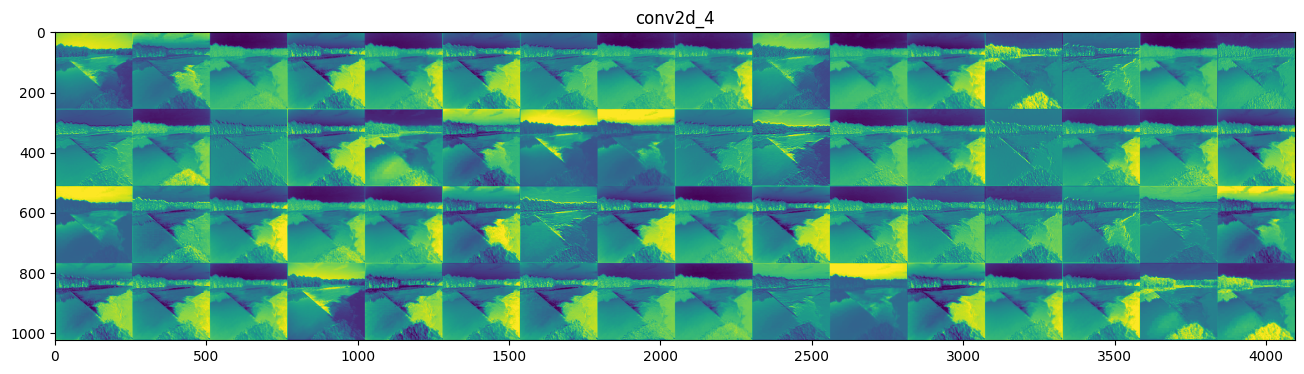

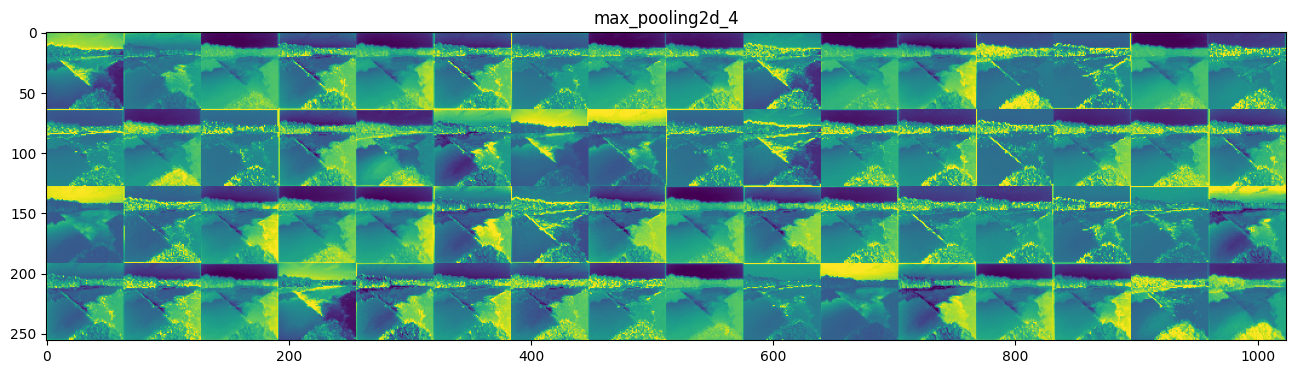

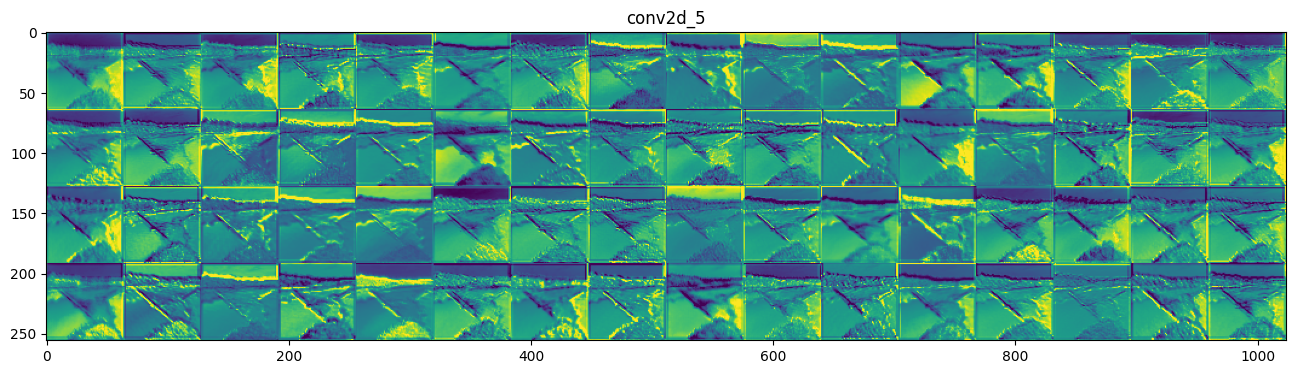

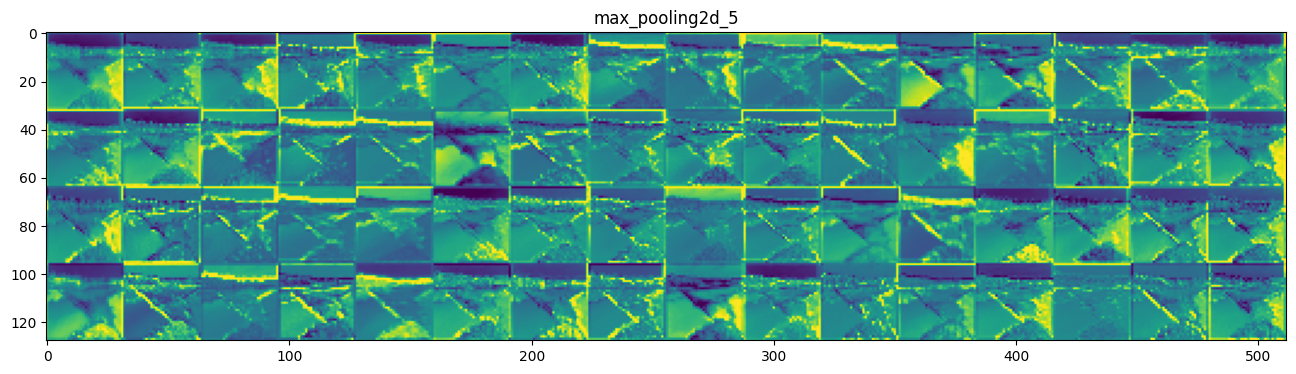

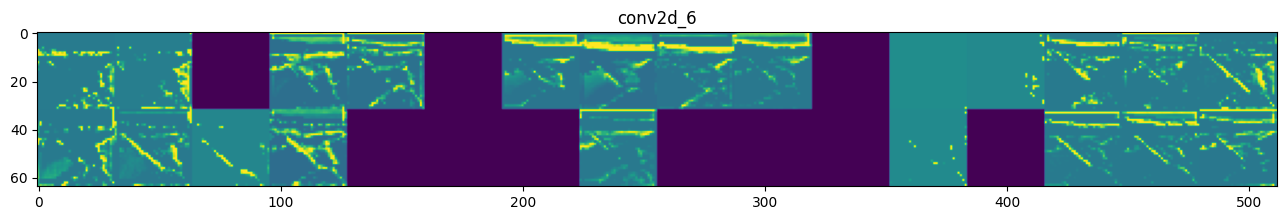

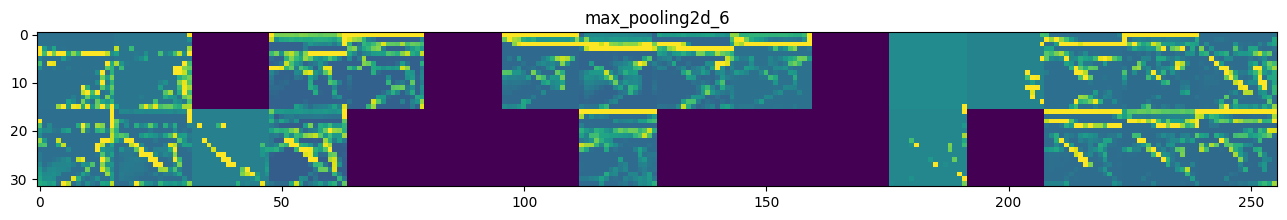

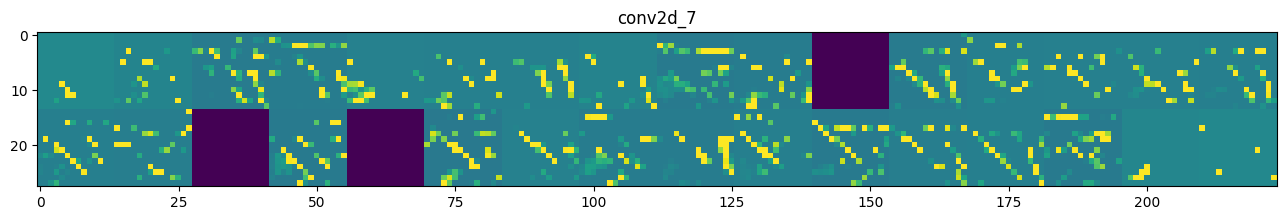

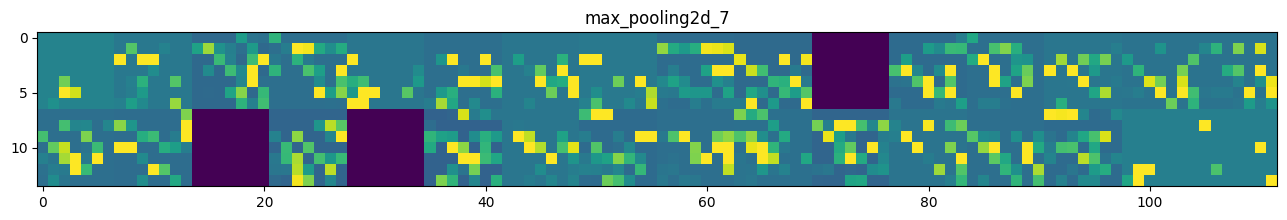

In [64]:
import matplotlib.pyplot as plt

layer_names = []
for layer in best_model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    print(layer_name)
    if ("flatten" in layer_name): break

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')